In [6]:
import numpy as np
import pandas as pd
import time
import cv2
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from pyntcloud import PyntCloud as pc
from tqdm import tqdm_notebook as tqdm
import numba as nb

Imports from my own libraries

In [7]:
from Kinect import Kinect
from Planes import find_plane, distance_from_plane
from watershed import watershed

In [8]:
USE_NUMBA = True

Grab a pointcloud from the Kinect

In [9]:
k = Kinect(debug=True)
k.start()
k.wait_for_init()
point_cloud = k.get_pointcloud()
k.stop()

Packet pipeline: OpenCLPacketPipeline
Number of devices: 1
Init done


Display the pointcloud using Pyntcloud

In [10]:
points = pd.DataFrame(point_cloud, columns=['x', 'y', 'z', 'red', 'green', 'blue'])
cloud = pc(points)
cloud.plot(IFrame_shape=(1200, 700), point_size=0.001)

Stopping device
Closing device
Device stopped and closed


A method for getting 3 random points from a set of points

In [11]:
def get_rand_points(points):
    
    r = np.random.choice(range(len(points)), 3)
    p = points[r]

    return p

A method for getting the difference between two multidimensional arrays

In [12]:
# from: https://stackoverflow.com/a/9271260/6588972
def multidim_diff(arr1, arr2):
    arr1_view = arr1.view([('',arr1.dtype)]*arr1.shape[1])
    arr2_view = arr2.view([('',arr2.dtype)]*arr2.shape[1])
    diff = np.setdiff1d(arr1_view, arr2_view)
    return diff.view(arr1.dtype).reshape(-1, arr1.shape[1])

Our planes are of the form $ax+by+cz=d$, but we fit to the form $ax+by+c=z$ in order to solve $Ax=B$.<br>
Where $
\mathbf{A} = 
    \begin{vmatrix}
        x_1 & y_1 & 1 \\
        x_2 & y_2 & 1 \\
        \vdots & \vdots & \vdots \\
        x_n & y_n & 1
    \end{vmatrix}
$, 
$
x = \begin{vmatrix}
        a \\
        b \\
        c
    \end{vmatrix}
$ and
$
\mathbf(B) = 
    \begin{vmatrix}
    z_1 \\
    z_2 \\
    \vdots \\
    z_n
    \end{vmatrix}
$ <br><br>
The following method fits the plane, and converts the parameters to the form we need.

In [13]:
def fit_plane_to_points(points, plane_params):
    M = np.zeros(points.shape)
    M[:,:2] = points[:,:2]
    M[:,2] = 1
    z = np.zeros((points.shape[0], 1))
    z = points[:,2]
    
    p, res, rnk, s = lstsq(M, z)
    #print(p)
    
    a = plane_params[0]
    b = plane_params[1]
    c = plane_params[2]
    d = plane_params[3]
    
    fit_a = -p[0] * c
    fit_b = -p[1] * c
    fit_c = c
    fit_d = -p[2] * c

    return fit_a, fit_b, fit_c, fit_d

In [14]:
def do_ransac(points, mask_on_points, limit, iterations=50):
    """
    points: all points in the cloud
    mask_on_points: 1d array of bool values, true value indicates point can be evaluated on
    limit: distance limit for ransac
    iterations: iterations for ransac
    """
    best_fit = {"num": 0,
                "inliers": None,
                "plane": None,
                "dists": None,
                "mask": None}
    
    # Get valid points, based on mask
    valid_points = points[mask_on_points]
    
    for i in tqdm(range(iterations)):
        p1, p2, p3 = get_rand_points(valid_points)

        p_a, p_b, p_c, p_d = find_plane(p1, p2, p3)
        
        # Find number of inliers
        dists = distance_from_plane(valid_points, p_a, p_b, p_c, p_d)
        inliers = valid_points[dists<limit]
        
        # If number of inliers is highest yet
        if inliers.shape[0] > best_fit["num"]:
            # Fit a new plane to these inliers
            fit_params = fit_plane_to_points(inliers, (p_a, p_b, p_c, p_d))
            
            # Get all distances to this new plane
            fit_dists = distance_from_plane(points, *fit_params)
            
            #fit_inliers = points[fit_dists<limit]
            # Get a mask, True where distance is less than limit
            fit_inliers = fit_dists < limit
            fit_inliers = np.logical_and(fit_inliers, mask_on_points)
            
            # Get a mask of outliers
            fit_outliers = np.logical_not(fit_inliers)
            
            # Mask of valid points, if this fit is used
            new_mask = np.logical_and(mask_on_points, fit_outliers)
            
            best_fit["num"] = inliers.shape[0]
            best_fit["inliers"] = fit_inliers
            best_fit["plane"] = fit_params
            best_fit["dists"] = fit_dists
            best_fit["mask"] = new_mask
    
    return best_fit

In [15]:
def find_planes(point_cloud, limit=0.1, ransac_iterations=50, stop_at=3):
    planes = []
    
    ps = point_cloud[:,:3]
    #all_ps = point_cloud[:,:3]
    mask = np.ones(ps.shape[0], dtype=np.bool)
    
    while(ps.shape[0] > 10000):
        fit = do_ransac(ps, mask, limit, ransac_iterations)
        planes.append(fit)
        mask = fit["mask"]
        
        #ps = multidim_diff(np.ascontiguousarray(ps), np.ascontiguousarray(fit["inliers"]))
        
        if len(planes) == stop_at:
            break
    
    return planes

Perform RANSAC

In [16]:
std_limit = np.std(point_cloud[:,:3]) / 20
print("std limit: {}".format(std_limit))
planes = find_planes(point_cloud, limit=std_limit, ransac_iterations=100, stop_at=3)

std limit: 0.3057067447714545


In [17]:
print("Planes found: {}".format(len(planes)))

Planes found: 3


Color a pointcloud with the points in planes, for visualization

In [18]:
pc_show = np.copy(point_cloud)

np.putmask(pc_show[:,5], planes[0]["inliers"], 255.0)
np.putmask(pc_show[:,4], planes[1]["inliers"], 255.0)
np.putmask(pc_show[:,3], planes[2]["inliers"], 255.0)

Show the planes

In [19]:
points = pd.DataFrame(pc_show, columns=['x', 'y', 'z', 'red', 'green', 'blue'])
#points.describe()
cloud = pc(points)
cloud.plot(IFrame_shape=(1200, 700), point_size=0.001)

- Points needs to be continous
- Points needs to be white
- Bounding box must be found

Try converting one plane to an image, so we can use various methods for images on it.

In [20]:
p_plane = point_cloud[planes[0]["inliers"]]
x_max = np.max(p_plane[:,0])
x_min = np.min(p_plane[:,0])
y_max = np.max(p_plane[:,1])
y_min = np.min(p_plane[:,1])

print("Max x: {}, min x: {}".format(x_max, x_min))
print("Max y: {}, min y: {}".format(y_max, y_min))

Max x: 9.81313440820322, min x: -6.06900804297792
Max y: 3.9955078440229954, min y: -6.153119865614725


In [21]:
p_plane[:,0] -= x_min
p_plane[:,1] -= y_min

In [22]:
new_x_max = np.max(p_plane[:,0])
new_x_min = np.min(p_plane[:,0])
new_y_max = np.max(p_plane[:,1])
new_y_min = np.min(p_plane[:,1])

print("Max x: {}, min x: {}".format(new_x_max, new_x_min))
print("Max y: {}, min y: {}".format(new_y_max, new_y_min))

Max x: 15.88214245118114, min x: 0.0
Max y: 10.14862770963772, min y: 0.0


In [23]:
num_points = len(p_plane)
print("Number of points: {}".format(num_points))

Number of points: 61781


In [24]:
pic_format = new_x_max / new_y_max
print("Format: {}".format(pic_format))

Format: 1.5649546821092417


Let $n$ be the number of points in this plane, and $f$ be the format of the picture we are looking for. Then $x$ and $y$ are the sizes of the axis, so that $x \cdot y = n$ and $\frac{x}{y} = f$. Meaning $y = \sqrt{\frac{n}{f}}$ and $x = \sqrt{\frac{n}{f}} \cdot f$

In [25]:
y_size = int(np.ceil(np.sqrt(num_points/pic_format)))
x_size = int(np.ceil(y_size * pic_format))

print("X size: {}, Y size: {}".format(x_size, y_size))

X size: 312, Y size: 199


In [26]:
y_scale = y_size / new_y_max
x_scale = x_size / new_x_max

print("x scale: {}, y scale: {}".format(x_scale, y_scale))

x scale: 19.644704797166508, y scale: 19.608562427708147


In [27]:
# FLipping x and y for better visualization
im = np.zeros((y_size, x_size, 3), dtype=np.uint8)

for p in p_plane:
    x_temp = int(p[0] * x_scale - 1)
    y_temp = int(p[1] * y_scale - 1)
    r_temp = int(p[3])
    b_temp = int(p[4])
    g_temp = int(p[5])
    
    im[y_temp, x_temp] = (r_temp, b_temp, g_temp)

Perform watershed on the image we found.<br>
Using a short distance limit to ensure lots of regions, so region merging can be tested below)

In [28]:
ws = watershed()
ws.set_transform_limit(0.01)
ws_res = ws.get_regions(im)

Text(0.5,1,'Watershed')

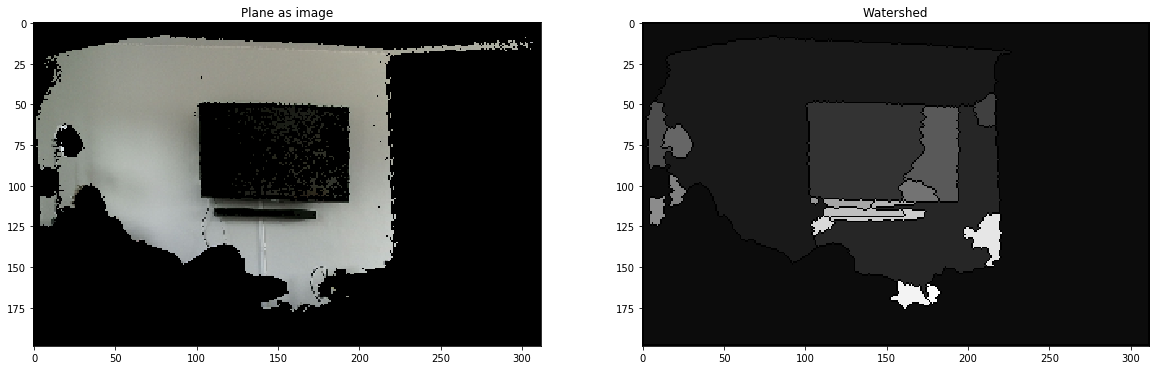

In [29]:
fig, subs = plt.subplots(1, 2, figsize=(20, 8))
subs[0].imshow(im)
subs[0].set_title("Plane as image")
subs[1].imshow(ws_res, cmap='gray')
subs[1].set_title("Watershed")

A list of the planes we found, and the amount of elements in each.

In [30]:
unique, counts = np.unique(ws_res, return_counts=True)
#counts, uniques = zip(*sorted(zip(counts, uniques), reverse=True))

print(counts)
print(unique)

[ 2662 33906 13471  4561  3779   192   378  1245   233   220   108   122
    12   108    58   194   132    88   356   203    60]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


A HSV version of the image

In [31]:
im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

Find set from watershed, that has colors that match.

In [32]:
good_vals = []
for u in unique:
    mean_h = np.mean(im_hsv[:,:,0][ws_res==u])
    mean_s = np.mean(im_hsv[:,:,1][ws_res==u])
    mean_v = np.mean(im_hsv[:,:,2][ws_res==u])
    print("For val {}  --  mean h: {}, mean s: {}, mean v: {}".format(u, mean_h, mean_s, mean_v))
    
    #if mean_h > 20 and mean_h < 70:
    #    good_vals.append(u)
    
    if mean_s < 20 and mean_v > 120:
        good_vals.append(u)

For val 0  --  mean h: 30.873779113448535, mean s: 14.900826446280991, mean v: 75.23328324567994
For val 1  --  mean h: 0.5577478912286911, mean s: 0.21671680528520026, mean v: 1.9820680705479856
For val 2  --  mean h: 44.232425209709746, mean s: 17.13970751985747, mean v: 158.0023754732388
For val 3  --  mean h: 60.76474457355843, mean s: 10.092962069721553, mean v: 171.22166191624643
For val 4  --  mean h: 4.922995501455412, mean s: 7.602804974861074, mean v: 4.288171473934903
For val 5  --  mean h: 28.270833333333332, mean s: 21.791666666666668, mean v: 163.08333333333334
For val 6  --  mean h: 48.08465608465608, mean s: 19.185185185185187, mean v: 138.10846560846562
For val 7  --  mean h: 4.903614457831325, mean s: 6.202409638554217, mean v: 6.3004016064257025
For val 8  --  mean h: 2.2532188841201717, mean s: 0.45064377682403434, mean v: 4.648068669527897
For val 9  --  mean h: 8.318181818181818, mean s: 23.509090909090908, mean v: 13.095454545454546
For val 10  --  mean h: 52.675

And the good sets are

In [33]:
print(good_vals)

[2, 3, 6, 10, 11, 12, 17, 18, 19]


Generate a range of colors, used for visualization.

In [34]:
# https://www.quora.com/How-do-I-generate-n-visually-distinct-RGB-colours-in-Python
import colorsys
 
def HSVToRGB(h, s, v):
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
    return (int(255*r), int(255*g), int(255*b))
 
def getDistinctColors(n):
    huePartition = 1.0 / (n + 1)
    return (HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, n))

Text(0.5,1,'Watershed regions with acceptable color')

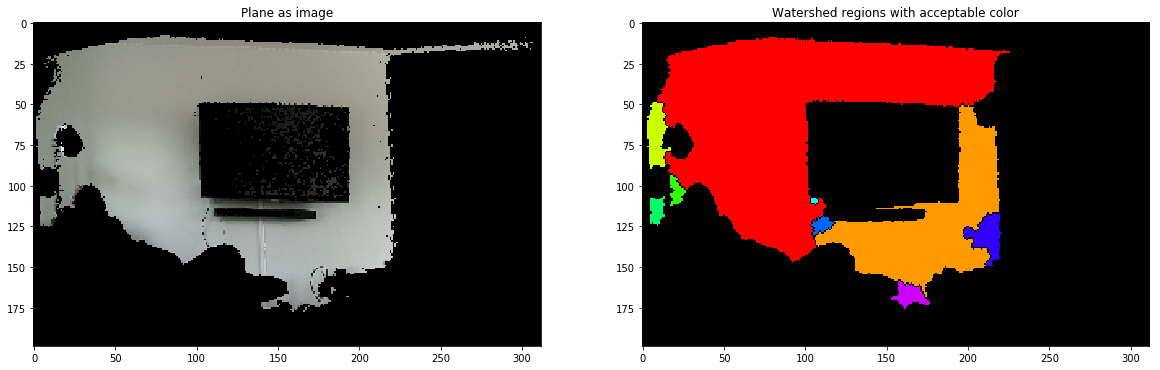

In [35]:
f, subs = plt.subplots(1, 2, figsize=(20, 10))

ws_res_color = np.zeros((ws_res.shape[0], ws_res.shape[1], 3), dtype=np.uint8)
colors = getDistinctColors(len(good_vals))

for g in good_vals:
    ws_res_color[ws_res==g] = next(colors)

subs[0].imshow(im)
subs[0].set_title("Plane as image")
subs[1].imshow(ws_res_color)
subs[1].set_title("Watershed regions with acceptable color")

### This is as far as I've gotten. Rest of document is not relevant.

- For each region in watershed, find all neighbour regions.
- Merge regions with similar color.
  - Or merge neighbours, as color is already validated.
- Repeat until no regions are merged.

In [36]:
coord_shape = ws_res.shape

In [37]:
y_mat = np.tile(np.arange(0, coord_shape[1]), (coord_shape[0], 1))
print(y_mat)

[[  0   1   2 ... 309 310 311]
 [  0   1   2 ... 309 310 311]
 [  0   1   2 ... 309 310 311]
 ...
 [  0   1   2 ... 309 310 311]
 [  0   1   2 ... 309 310 311]
 [  0   1   2 ... 309 310 311]]


In [38]:
x_mat = np.tile(np.arange(0, coord_shape[0]), (coord_shape[1], 1)).T
print(x_mat)

[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [196 196 196 ... 196 196 196]
 [197 197 197 ... 197 197 197]
 [198 198 198 ... 198 198 198]]


In [39]:
coord_mat = np.zeros((coord_shape[0], coord_shape[1], 2))
print(coord_mat.shape)
coord_mat[:,:,0] = x_mat
coord_mat[:,:,1] = y_mat

(199, 312, 2)


In [40]:
print(good_vals)
print(len(good_vals))

[2, 3, 6, 10, 11, 12, 17, 18, 19]
9


Find the minimum distance between two sets, and the number of points with this distance

In [41]:
#@nb.jit(nb.types.Tuple((nb.float64, nb.int64))(nb.int64[:,:], nb.int64[:,:]))
@nb.jit(nopython=True)
def minimum_distance(points1, points2):
    min_dist = 100
    min_count = 100
    #for p1 in points1:
    for i1 in range(len(points1)):
        #for p2 in points2:
        for i2 in range(len(points2)):
            d = np.sqrt((points1[i1][0] - points2[i2][0])**2 + (points1[i1][1] - points2[i2][1])**2)
            
            if d < min_dist:
                min_dist = d
                min_count = 1
            elif d == min_dist:
                min_count += 1
    return min_dist, min_count

In [42]:
#nb_minimum_distance = nb.jit(minimum_distance, nopython=True)
#minimum_distance.inspect_types()

This is very slow, would like to find some way to do it vectorized.

In [43]:

p1 = np.array([[1, 1],
               [1, 2],
               [3, 4]])

p1 = np.random.rand(10, 2)

p2 = np.array([[2, 1],
               [2, 2],
               [3, 4],
               [5, 5]])

p2 = np.random.rand(100, 2)

In [44]:
minimum_distance(p1, p2)
%timeit minimum_distance(p1, p2)

2.63 µs ± 52 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [45]:
#nb_minimum_distance(p1, p2)
#%timeit nb_minimum_distance(p1, p2)

NameError: name 'nb_minimum_distance' is not defined

In [46]:
def find_neighbours(region_vals, watershed_image):
    neighbours = {}
    
    for g1 in tqdm(region_vals):
        neighbours[g1] = []
        g1_set = coord_mat[watershed_image==g1]
        for g2 in region_vals:
            if g1 == g2:
                continue
            g2_set = coord_mat[watershed_image==g2]
            #g1_g2_dist = minimum_distance(g1_set, g2_set)
            g1_g2_dist = minimum_distance(g1_set, g2_set)
            # Minimum distance is sqrt(2)
            if g1_g2_dist[0] <= np.sqrt(2):
                neighbours[g1].append(g2)
    return neighbours

In [48]:
#nb = find_neighbours(good_vals, ws_res)
#for k, v in nb.items():
#    print("{}: {}".format(k, v))

In [49]:
#nb = numba_find_neighbours(good_vals, ws_res)
#for k, v in nb.items():
#    print("{}: {}".format(k, v))

Merge the first found neighbours.<br>
Consider optimizing by merging all neighbours, that doesnt share neighbors.

In [50]:
#@nb.jit(nb.types.Tuple())
def merge_regions(regions, ws):
    neighbours = find_neighbours(regions, ws)
    merge_done = False
    
    for r in regions:
        if r not in neighbours.keys():
            continue
        if len(neighbours[r]) == 0:
            continue
            
        for n in neighbours[r]:
            print("Merging {} into {}".format(n, r))
            
            #n1 = neighbours[r][0]
            regions.remove(n)

            ws[ws==n] = r
            merge_done = True
        
        break

    return regions, ws, merge_done

In [51]:
#@nb.jit(nb.types.Tuple((nb.int64, nb.int64[:,:]))(nb.int64, nb.int64[:,:]))
def merge_all_regions(regions, ws):
    merge_done = True
    while(merge_done):
        regions, ws, merge_done = merge_regions(regions, ws)
        print("Regions left: {}".format(len(regions)))
    
    print("Done")
    return regions, ws

In [53]:
#sdcsc

In [54]:
g = good_vals.copy()
w = np.copy(ws_res)

print("")
print("Number of regions at start: {}".format(len(good_vals)))

regions, ws = merge_all_regions(g, w)


Number of regions at start: 9



Merging 3 into 2
Merging 6 into 2
Merging 10 into 2
Merging 12 into 2
Merging 17 into 2
Regions left: 4



Merging 18 into 2
Merging 19 into 2
Regions left: 2



Regions left: 2
Done


Text(0.5,1,'Watershed with merged regions')

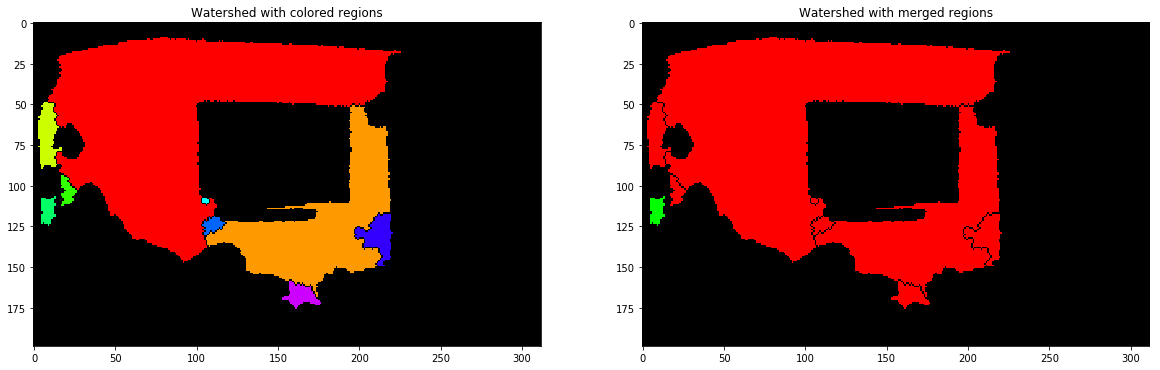

In [55]:
f, subs = plt.subplots(1, 2, figsize=(20, 10))

ws_new_regions = np.zeros((ws_res.shape[0], ws_res.shape[1], 3), dtype=np.uint8)
colors = getDistinctColors(len(regions))

for r in regions:
    ws_new_regions[ws==r] = next(colors)

subs[0].imshow(ws_res_color)
subs[0].set_title("Watershed with colored regions")
subs[1].imshow(ws_new_regions)
subs[1].set_title("Watershed with merged regions")

In [56]:
print(regions)
print(len(regions))

[2, 11]
2


In [57]:
ws_res_color = np.zeros((ws_res.shape[0], ws_res.shape[1], 3), dtype=np.uint8)

In [58]:
val = unique[3]
print(val)
ws_res_color[ws_res==val] = (0, 0, 255)

3


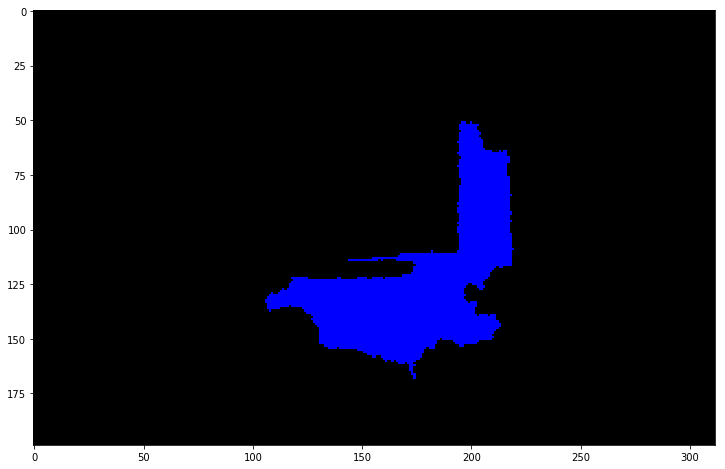

In [59]:
fig = plt.figure(figsize=(15, 8))
plt.imshow(ws_res_color)